# Fine Tune LLM

## Introduction

Assume that you built a kickass AI application using a large language model (LLM) like GPT-4 or LLaMA. You showed it to your teammates, your manager, your client. Everyone is happy. You get the go ahead to deploy it to production.

After 1 month, your client comes back to you. He is not happy with the cost of running the application. The inference cost is too high. Instead of saving cost, the application is costing more money than before. He wants you to reduce the cost of running the application.
You think to yourself, "Hmm, maybe I can fine-tune a smaller model on my specific use case. That should reduce the inference cost significantly". You replace the model, test it with some use cases, and the results were satisfactory. Your client is happy again. You get the go ahead to deploy the model to production.

After 3 months, your client comes back to you again. This time, he is not happy with the quality of the responses from the model. The model is not able to handle some specific queries related to his domain. He wants you to improve the quality of the responses. You think to yourself, "Hmm, maybe I can fine-tune the model further on more specific data related to his domain". You gather more data, fine-tune the model again, test it with some use cases, and the results were satisfactory. Your client is happy again. You get the go ahead to deploy the model to production.

Above is an example of how fine-tuning can help improve the performance and reduce the cost of running an AI application. Fine-tuning allows you to adapt a pre-trained model to your specific use case, making it more efficient and effective. In the following sections, we will explore how to fine-tune large language models (LLMs). We will also discuss how to deploy the fine-tuned models using AWS SageMaker.

## What exactly is Fine-Tuning?

Fine-tuning is the process of taking a pre-trained model and training it further on a specific dataset to adapt it to a particular task or domain. This involves updating the model's weights based on the new data while retaining the knowledge learned during the initial pre-training phase. Fine-tuning can be done using various techniques, such as full model fine-tuning, parameter-efficient fine-tuning (PEFT) which further includes methods like LoRA (Low-Rank Adaptation), and adapter-based fine-tuning.

## Comparison with RAG

You might be wondering, "Is fine tuning the only way to adapt LLMs to specific tasks? Is there any other simpler way?" The answer is yes. Another popular approach is Retrieval-Augmented Generation (RAG). RAG combines pre-trained language models with external knowledge sources, such as databases or document collections, to enhance the model's ability to generate relevant and accurate responses. Instead of fine-tuning the entire model, RAG retrieves relevant information from the external source and incorporates it into the generation process.

But here is the minor observation, Although RAG is simpler and preferable in many scenarios, it may not always be sufficient for highly specialized tasks that require deep domain knowledge or specific language patterns. Sometime you might want the model to reply in a specific way that is only possible through fine-tuning. In such cases, fine-tuning becomes necessary to achieve the desired performance.

The ideal approach often involves a combination of both fine-tuning and RAG, where the model is fine-tuned on a smaller, domain-specific dataset while also leveraging external knowledge sources for enhanced performance. This again leads to multiple issues, like need for using and maintaining multiple systems, increased complexity, etc. So, it is always a trade-off between simplicity and performance.

## Types of Fine-Tuning Techniques

There are several techniques for fine-tuning large language models, each with its own advantages and disadvantages. Some of the most common techniques include:

### Full Model Fine-Tuning

Involves updating all the parameters of the pre-trained model. This approach can lead to better performance but requires significant computational resources and large amounts of labeled data.
In this case all the weights of the model are updated during training. The disadvantage of this approach is that it is computationally expensive and requires a lot of memory. It can also lead to overfitting if the dataset is small. It can also lead to catastrophic forgetting, where the model forgets the knowledge it learned during pre-training.

### Parameter-Efficient Fine-Tuning (PEFT)

Involves updating only a small subset of the model's parameters, making it more efficient in terms of computation and memory usage. Techniques like LoRA (Low-Rank Adaptation) fall under this category. PEFT methods are particularly useful when dealing with large models and limited computational resources. They allow for faster training times and reduced memory consumption while still achieving good performance on specific tasks.

PEFT is futher divided into multiple techniques like LoRA, Adapters, Prefix Tuning, etc. Among these, LoRA has gained significant popularity due to its simplicity and effectiveness. LoRA works by introducing low-rank matrices into the model's architecture, allowing for efficient adaptation without modifying the original weights extensively.

## Let's Fine-Tune a Model

In this blog, we will focus on PEFT using LoRA due to its efficiency and effectiveness for many use cases.

We will use Qwen/Qwen1.5-0.5B-Chat model from Qwen series by Alibaba for demonstration purposes. However, the same concepts can be applied to other LLMs like GPT, LLaMA, etc. We will fine-tune it on counsel chat dataset from Huggingface which contains mental health related questions and answers.  
Basically we will build a mental health chatbot using fine-tuned Qwen model. Note that this is just for demonstration purposes. In real world, mental health related applications should be built with extreme caution and after consulting domain experts.


**Import necessary libraries and load the dataset.**

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments, DataCollatorForLanguageModeling

from datasets import Dataset
import pandas as pd
from peft import LoraConfig, get_peft_model, TaskType
from peft import PeftModel, PeftConfig
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

The dataset can be found [here](https://huggingface.co/datasets/counselchat/counselchat). It contains around 1000 question-answer pairs related to mental health counseling.

In [3]:
df = pd.read_csv("hf://datasets/nbertagnolli/counsel-chat/20220401_counsel_chat.csv")

Sample data from the dataset

In [4]:
df.sample(5)

,questionID,questionTitle,questionText,questionLink,topic,therapistInfo,therapistURL,answerText,upvotes,views
2458,920,The girls at my coming-of-age party don't like...,"I'm having a quinceañera, and the girls don't ...",https://counselchat.com/questions/the-girls-at...,social-relationships,"Sherry Katz, LCSWCouples and Family Therapist,...",https://counselchat.com/therapists/sherry-katz...,How did you find out that the girls aren't hap...,0,101
1139,355,How do I move on?,I'm obsessing about a terrible breakup. Everyt...,https://counselchat.com/questions/how-do-i-mov...,relationship-dissolution,Dr. Meredyth LawrynceServing Clients Nationwide,https://counselchat.com/therapists/dr-meredyth...,A large part of moving on is taking time to gr...,0,25
2611,933,How would I know if I have the right therapist?,How do you know you have the right therapist f...,https://counselchat.com/questions/how-would-i-...,counseling-fundamentals,Janna KinnerFlourish Christian Counseling,https://counselchat.com/therapists/janna-kinner,"This is a really important question, because y...",0,2187
2131,751,I feel like my fiance still in love with his ex,I was talking to my fiance about changing my h...,https://counselchat.com/questions/i-feel-like-...,relationships,"Sherry Katz, LCSWCouples and Family Therapist,...",https://counselchat.com/therapists/sherry-katz...,Maybe your finance's hair preference for you r...,0,40
2219,820,My girlfriend broke up with me but I want her ...,Me and my girlfriend just broke up. She said s...,https://counselchat.com/questions/my-girlfrien...,relationships,"Kristi King-Morgan, LMSWSocial Worker, Psychot...",https://counselchat.com/therapists/kristi-king...,I am sorry to hear of these troubles. I see a ...,2,140


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2775 entries, 0 to 2774
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   questionID     2775 non-null   int64 
 1   questionTitle  2775 non-null   object
 2   questionText   2636 non-null   object
 3   questionLink   2775 non-null   object
 4   topic          2775 non-null   object
 5   therapistInfo  2775 non-null   object
 6   therapistURL   2775 non-null   object
 7   answerText     2749 non-null   object
 8   upvotes        2775 non-null   int64 
 9   views          2775 non-null   int64 
dtypes: int64(3), object(7)
memory usage: 216.9+ KB


In [6]:
df=df[["questionText", "topic"]]
df=df.drop_duplicates().dropna()
df=df.rename(columns={"questionText": "question", "topic": "answer"})
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 865 entries, 0 to 2769
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  865 non-null    object
 1   answer    865 non-null    object
dtypes: object(2)
memory usage: 20.3+ KB


Lets check the distribution of topics in the dataset.

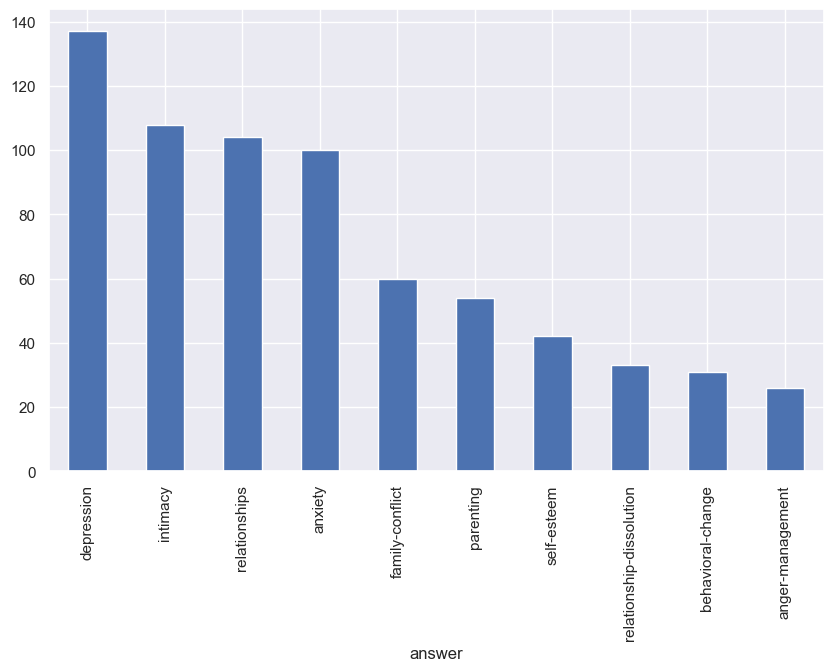

In [7]:
plt.figure(figsize=(10,6))
df["answer"].value_counts().head(10).plot.bar();

In [8]:
df.head()

,question,answer
0,I have so many issues to address. I have a his...,depression
86,I have been diagnosed with general anxiety and...,depression
91,My mother is combative with me when I say I do...,depression
93,There are many people willing to lovingly prov...,depression
96,My girlfriend just quit drinking and she becam...,depression


**Load the pre-trained model and tokenizer.**

In [9]:
device = "mps"
model_name = "Qwen/Qwen1.5-0.5B-Chat"
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map=device
)
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True, trust_remote_code=True)

**Function to preprocess the data for Qwen model in simple Q & A based format.**

In [ ]:
from transformers import AutoTokenizer

def preprocess_simple_qwen(df, tokenizer_name, max_length=256):
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, use_fast=True, trust_remote_code=True)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    processed = []

    # Pre-tokenize all at once for speed (batch mode)
    questions = df["question"].astype(str).str.strip().tolist()
    answers = [f"Based on what you've described, this sounds like {row['answer'].strip()}." for _, row in df.iterrows()]
    texts = [f"{q}\n{a}" for q, a in zip(questions, answers)]


    # Tokenize full text and questions in batch mode (vectorized)
    tokenized_all = tokenizer(
        texts,
        truncation=True,
        padding="max_length",
        max_length=max_length,
    )

    # Tokenize only questions (without padding) to get split lengths
    question_tokenized = tokenizer(
        questions,
        truncation=True,
        max_length=max_length,
        add_special_tokens=True,  # ensure same start token handling
    )

    for i in range(len(df)):
        input_ids = tokenized_all["input_ids"][i]
        attention_mask = tokenized_all["attention_mask"][i]

        q_len = len(question_tokenized["input_ids"][i])
        labels = input_ids.copy()
        labels[:q_len] = [-100] * q_len  # mask the question part

        processed.append({
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
        })

    return processed


def preprocess_qwen_chatml(df, tokenizer_name, max_length=512):
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, use_fast=True, trust_remote_code=True)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    processed = []

    for _, row in df.iterrows():
        instruction = row["question"]
        response = row["answer"]

        chat_prompt = (
            "<|im_start|>system\n"
            "You are a mental health assistant. Based on the user's description, respond with a single sentence indicating the most relevant diagnosis from the mental health domain.<|im_end|>\n"
            f"<|im_start|>user\n{instruction}<|im_end|>\n"
            f"<|im_start|>assistant\nBased on what you've described, this sounds like {response}.<|im_end|>"
        )

        # Tokenize full prompt
        tokenized = tokenizer(chat_prompt, truncation=True, padding="max_length", max_length=max_length)

        # Mask everything before assistant's response in labels
        assistant_start = chat_prompt.find("<|im_start|>assistant")
        response_start = tokenizer(chat_prompt[:assistant_start], truncation=True, max_length=max_length, padding="max_length")["input_ids"]
        labels = tokenized["input_ids"].copy()
        labels[:len(response_start)] = [-100] * len(response_start)

        processed.append({
            "chat_prompt": chat_prompt,
            "input_ids": tokenized["input_ids"],
            "attention_mask": tokenized["attention_mask"],
            "labels": labels
        })

    return processed



**Check the model config**

In [15]:
model.config

Qwen2Config {
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 2816,
  "layer_types": [
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention",
    "full_attention"
  ],
  "max_position_embeddings": 32768,
  "max_window_layers": 21,
  "model_type": "qwen2",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "num_key_value_heads": 16,
  "rms_norm_eps": 1e-06,
  "

**Following is the structure of the neural network model we will be using**

In [16]:
print(model)

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 1024)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (o_proj): Linear(in_features=1024, out_features=1024, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=1024, out_features=2816, bias=False)
          (up_proj): Linear(in_features=1024, out_features=2816, bias=False)
          (down_proj): Linear(in_features=2816, out_features=1024, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((1024,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((1024,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((1024,), eps=1e-06)
    (rotary_emb): 

Create a LoraConfig object with desired parameters. Here, we set the rank to 8, alpha to 16, and dropout to 0.05 and target modules to q_proj, k_proj, v_proj, o_proj.

Why these target modules? Because Qwen model uses QKV attention mechanism and these are the projection layers for query, key, value and output respectively. By applying LoRA to these layers, we can effectively adapt the attention mechanism of the model to our specific task. 
The Attention layers are crucial components of transformer-based models like Qwen. They allow the model to focus on different parts of the input sequence when making predictions. By fine-tuning these layers using LoRA, we can help the model learn to pay attention to the most relevant information for our specific task, which in this case is mental health counseling.

In [10]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM, 
    # target_modules=["q_proj", "k_proj", "v_proj", "o_proj"]
)

In [38]:
chatbot = pipeline("text-generation", model=model, tokenizer=tokenizer);

Device set to use mps


In [30]:
issue = """<|im_start|>system\n"
"You are a mental health assistant. Based on the user's description, respond with a single sentence indicating the most relevant diagnosis from the mental health domain.<|im_end|>\n"
<|im_start|>user
I am broke and I lost my job<|im_end|>
<|im_start|>assistant
"""
response = chatbot(issue, max_new_tokens=100, do_sample=True, temperature=0.7)
generated = response[0]['generated_text']
assistant_start = generated.find("<|im_start|>assistant\n") + len("<|im_start|>assistant\n")
reply = generated[assistant_start:].strip().split("<|im_end|>")[0].strip()
print("Assistant:", reply)

Assistant: The most relevant diagnosis from the mental health domain is depression.


Before fine tuning, lets evaluate the base model on some sample questions from the dataset.

In [11]:
model = get_peft_model(model, lora_config)
model.print_trainable_parameters();

'NoneType' object has no attribute 'cadam32bit_grad_fp32'
trainable params: 786,432 || all params: 464,774,144 || trainable%: 0.1692


/opt/miniconda3/lib/python3.12/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


In [12]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2ForCausalLM(
      (model): Qwen2Model(
        (embed_tokens): Embedding(151936, 1024)
        (layers): ModuleList(
          (0-23): 24 x Qwen2DecoderLayer(
            (self_attn): Qwen2Attention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=1024, out_features=1024, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1024, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=1024, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): Linear(in_feat

In [13]:
hf_dataset = Dataset.from_pandas(df[["question", "answer"]])

In [ ]:
tokenized_dataset_chatml = hf_dataset.map(lambda ex: preprocess_qwen_chatml(pd.DataFrame([ex]), model_name)[0]);
# tokenized_dataset_simple = hf_dataset.map(lambda ex: preprocess_simple_qwen(pd.DataFrame([ex]), model_name)[0]);

Map:   0%|          | 0/865 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset_simple[2]["question"], tokenized_dataset_simple[2]["answer"]

("My mother is combative with me when I say I don't want to talk with her about my depression.    She hasn't been supportive of me in the past and she isn't someone that I feel comfortable opening up to. She constantly tries to instigate conversations where she asks me questions that I don't want to or can't answer. I tell her I don't want to talk and she starts arguments with me.    How can I get her to understand?",
 'depression')

In [ ]:
tokenized_dataset_simple[0]["input_ids"][:10]

[40, 614, 773, 1657, 4714, 311, 2621, 13, 358, 614]

In [23]:
# tokenized_dataset_simple.save_to_disk("../data/processed/preprocess_simple_qwen")
tokenized_dataset_chatml.save_to_disk("../data/processed/preprocess_chatml_qwen")

Saving the dataset (0/1 shards):   0%|          | 0/865 [00:00<?, ? examples/s]

In [14]:
# load the processed dataset
# tokenized_dataset_simple = Dataset.load_from_disk("../data/processed/preprocess_simple_qwen")
tokenized_dataset_chatml = Dataset.load_from_disk("../data/processed/preprocess_chatml_qwen")

In [15]:
tokenized_dataset_chatml

Dataset({
    features: ['question', 'answer', '__index_level_0__', 'chat_prompt', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 865
})

**Setup the Trainer and Training Arguments.**

In [ ]:
training_args = TrainingArguments(
    output_dir="./finetuned-model",
    per_device_train_batch_size=4,
    num_train_epochs=4,
    logging_dir='./logs',
    # save_steps=500,
    logging_steps=100,
    save_strategy="no",
    label_names=["labels"],  # Explicitly specify label names for PEFT models
    save_total_limit=1,
)

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset_chatml,
    processing_class=tokenizer,
    data_collator=data_collator,
);

In [19]:
trainer.train();

Step,Training Loss
100,3.240100
200,1.813000
300,1.644400
400,1.595900
500,1.571500
600,1.506100
700,1.561300
800,1.499400


In [20]:
trainer.save_model("./finetuned-model")

**Save the fine-tuned PEFT model**

In [21]:
peft_model_id = "./finetuned-model"
peft_config = PeftConfig.from_pretrained(peft_model_id)

# Load the base model
base_model = AutoModelForCausalLM.from_pretrained(peft_config.base_model_name_or_path, return_dict=True)

# Load adapter into base model
model = PeftModel.from_pretrained(base_model, peft_model_id)

# Merge LoRA weights into base model
merged_model = model.merge_and_unload()

merged_model.save_pretrained("./merged")

tokenizer = AutoTokenizer.from_pretrained(peft_config.base_model_name_or_path)
tokenizer.save_pretrained("./merged");

**Load the fine-tuned model for inference and test it on some sample questions.**

In [31]:
tuned_model = AutoModelForCausalLM.from_pretrained("./finetuned-model/merged", torch_dtype="auto")
tokenizer = AutoTokenizer.from_pretrained("./finetuned-model/merged", use_fast=True, trust_remote_code=True)

chatbot = pipeline("text-generation", model=tuned_model, tokenizer=tokenizer, device=0);

Device set to use mps:0


In [45]:
issue = """<|im_start|>system\n"
"You are a mental health assistant. Based on the user's description, respond with a single sentence indicating the most relevant diagnosis from the mental health domain.<|im_end|>\n"
<|im_start|>user
I am broke and I want to kill myself<|im_end|>
<|im_start|>assistant
"""
response = chatbot(issue, max_new_tokens=100, do_sample=True, temperature=0.7)
generated = response[0]['generated_text']
assistant_start = generated.find("<|im_start|>assistant\n") + len("<|im_start|>assistant\n")
reply = generated[assistant_start:].strip().split("<|im_end|>")[0].strip()
print("Assistant:", reply)

Assistant: Based on what you've described, this sounds like depression.
